<a href="https://colab.research.google.com/github/debashisdotchatterjee/MechGNN-Ep/blob/main/MechGNN%E2%80%93Epi_MAIN_CODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# ============================================
# REAL DATASET BUILDER (Colab): covid19dh -> CSV
# Creates: us_states_covid19dh.csv
# ============================================

!pip -q install covid19dh

import pandas as pd
import numpy as np
from datetime import date
from covid19dh import covid19
from google.colab import files

# ---- Choose time range (edit if you like) ----
START = date(2020, 3, 1)
END   = date(2021, 12, 31)

# ---- Download USA state-level data (level=2) ----
x, src = covid19("USA", level=2, start=START, end=END, raw=False)

print("Downloaded rows:", len(x))
print("Columns:", list(x.columns))
print("\nData sources returned by covid19dh (top):")
display(src.head())

# ---- Harmonize column names safely ----
# covid19dh typically returns columns like: date, iso_alpha_2, administrative_area_level_2,
# confirmed, deaths, recovered, population, etc. (exact names may vary by vintage/source).
df = x.copy()

# Ensure date column
if "date" not in df.columns:
    raise ValueError("No 'date' column found. Please print columns and share here.")

df["date"] = pd.to_datetime(df["date"])

# Region name: try common fields used by covid19dh
region_candidates = [
    "administrative_area_level_2",  # common for states/regions
    "administrative_area_level_1",
    "name",
    "region",
    "state"
]
region_col = next((c for c in region_candidates if c in df.columns), None)
if region_col is None:
    raise ValueError(f"Could not find a region column among: {region_candidates}. Columns are: {list(df.columns)}")

df = df.rename(columns={region_col: "region"})

# Identify confirmed/deaths/recovered/active/population columns if present
def pick_col(cands):
    return next((c for c in cands if c in df.columns), None)

confirmed_col = pick_col(["confirmed", "cases", "cumulative_confirmed", "cum_confirmed"])
deaths_col    = pick_col(["deaths", "cumulative_deaths", "cum_deaths"])
recovered_col = pick_col(["recovered", "cumulative_recovered", "cum_recovered"])
active_col    = pick_col(["active", "active_cases"])
pop_col       = pick_col(["population", "pop"])

if confirmed_col is None:
    raise ValueError("No confirmed/cases column found in covid19dh output. Please share the printed columns.")

# Fill missing numeric columns with 0 where appropriate
for c in [confirmed_col, deaths_col, recovered_col, active_col]:
    if c is not None:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Compute recovered (if absent -> 0)
if recovered_col is None:
    df["recovered"] = 0.0
else:
    df["recovered"] = df[recovered_col].fillna(0.0)

# Compute infected (prefer active if available; else confirmed - deaths - recovered)
if active_col is not None:
    df["infected"] = df[active_col].fillna(0.0)
else:
    d = df[deaths_col].fillna(0.0) if deaths_col is not None else 0.0
    df["infected"] = (df[confirmed_col].fillna(0.0) - d - df["recovered"]).clip(lower=0.0)

# Population (if missing -> 1 so model can run in normalized units)
if pop_col is None:
    df["population"] = 1.0
else:
    df["population"] = pd.to_numeric(df[pop_col], errors="coerce").fillna(1.0)

# Mobility feature: covid19dh is not a mobility database; set a neutral constant (truthful).
df["mobility"] = 1.0

# Keep only needed columns
out = df[["date", "region", "infected", "recovered", "population", "mobility"]].copy()

# Clean region names, drop null region rows
out["region"] = out["region"].astype(str).str.strip()
out = out[out["region"].notna() & (out["region"] != "")]

# Optional: remove aggregates (if any show up)
bad = {"Unknown", "US", "United States", "USA"}
out = out[~out["region"].isin(bad)]

# Ensure sorted
out = out.sort_values(["region", "date"]).reset_index(drop=True)

# Save
csv_path = "/content/us_states_covid19dh.csv"
out.to_csv(csv_path, index=False)
print("Saved:", csv_path, "shape:", out.shape)

display(out.head(10))
display(out.tail(10))

# Download to your computer (so you can upload to your main Colab notebook if you want)
files.download(csv_path)


We have invested a lot of time and effort in creating COVID-19 Data Hub, please cite the following when using it:

	Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.

A BibTeX entry for LaTeX users is

	@Article{,
		title = {COVID-19 Data Hub},
		year = {2020},
		doi = {10.21105/joss.02376},
		author = {Emanuele Guidotti and David Ardia},
		journal = {Journal of Open Source Software},
		volume = {5},
		number = {51},
		pages = {2376},
	}

To hide this message use 'verbose = False'.
Downloaded rows: 22904
Columns: ['id', 'date', 'vaccines', 'tests', 'confirmed', 'recovered', 'deaths', 'hosp', 'vent', 'icu', 'population', 'school_closing', 'workplace_closing', 'cancel_events', 'gatherings_restrictions', 'transport_closing', 'stay_home_restrictions', 'internal_movement_restrictions', 'international_movement_restrictions', 'information_campaigns', 'testing_policy', 'contact_tracing', 'stringency_index', 'iso_alpha_3'

,iso_alpha_3,administrative_area_level,data_type,url,title,year,bibtype,author,institution,textVersion
696,USA,2,latitude,https://github.com/CSSEGISandData/COVID-19,Johns Hopkins Center for Systems Science and E...,2020,NaN,NaN,NaN,NaN
697,USA,2,longitude,https://github.com/CSSEGISandData/COVID-19,Johns Hopkins Center for Systems Science and E...,2020,NaN,NaN,NaN,NaN
698,USA,2,population,https://github.com/CSSEGISandData/COVID-19,Johns Hopkins Center for Systems Science and E...,2020,NaN,NaN,NaN,NaN
699,USA,2,vaccines,https://ourworldindata.org/us-states-vaccinations,Our World in Data,2021,NaN,NaN,NaN,NaN
700,USA,2,confirmed,https://github.com/nytimes/covid-19-data,The New York Times,2020,NaN,NaN,NaN,NaN


Saved: /content/us_states_covid19dh.csv shape: (22904, 6)


,date,region,infected,recovered,population,mobility
0,2020-03-01,Alabama,0.0,0,4903185.0,1.0
1,2020-03-02,Alabama,0.0,0,4903185.0,1.0
2,2020-03-03,Alabama,0.0,0,4903185.0,1.0
3,2020-03-04,Alabama,0.0,0,4903185.0,1.0
4,2020-03-05,Alabama,0.0,0,4903185.0,1.0
5,2020-03-06,Alabama,0.0,0,4903185.0,1.0
6,2020-03-07,Alabama,0.0,0,4903185.0,1.0
7,2020-03-08,Alabama,0.0,0,4903185.0,1.0
8,2020-03-09,Alabama,0.0,0,4903185.0,1.0
9,2020-03-10,Alabama,0.0,0,4903185.0,1.0


,date,region,infected,recovered,population,mobility
22894,2021-04-04,Wyoming,2197.0,53550,578759.0,1.0
22895,2021-04-05,Wyoming,2279.0,53550,578759.0,1.0
22896,2021-04-06,Wyoming,2368.0,53550,578759.0,1.0
22897,2021-04-07,Wyoming,2449.0,53550,578759.0,1.0
22898,2021-04-08,Wyoming,2551.0,53550,578759.0,1.0
22899,2021-04-09,Wyoming,2622.0,53550,578759.0,1.0
22900,2021-04-10,Wyoming,2622.0,53550,578759.0,1.0
22901,2021-04-11,Wyoming,2622.0,53550,578759.0,1.0
22902,2021-04-12,Wyoming,2737.0,53550,578759.0,1.0
22903,2021-04-13,Wyoming,2737.0,53550,578759.0,1.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Device: cpu
Outputs will be saved to: /content/MechGNN_Epi_Run_20260209_053246
Found CSV at: /content/us_states_covid19dh.csv
Data shape: (22904, 6)


,date,region,infected,recovered,population,mobility
0,2020-03-01,Alabama,0.0,0,4903185.0,1.0
1,2020-03-02,Alabama,0.0,0,4903185.0,1.0
2,2020-03-03,Alabama,0.0,0,4903185.0,1.0
3,2020-03-04,Alabama,0.0,0,4903185.0,1.0
4,2020-03-05,Alabama,0.0,0,4903185.0,1.0


Regions: 56 ['Alabama', 'Alaska', 'American Samoa', 'Arizona', 'Arkansas', 'California'] ...
Dates: 2020-03-01 00:00:00 to 2021-04-13 00:00:00 T = 409


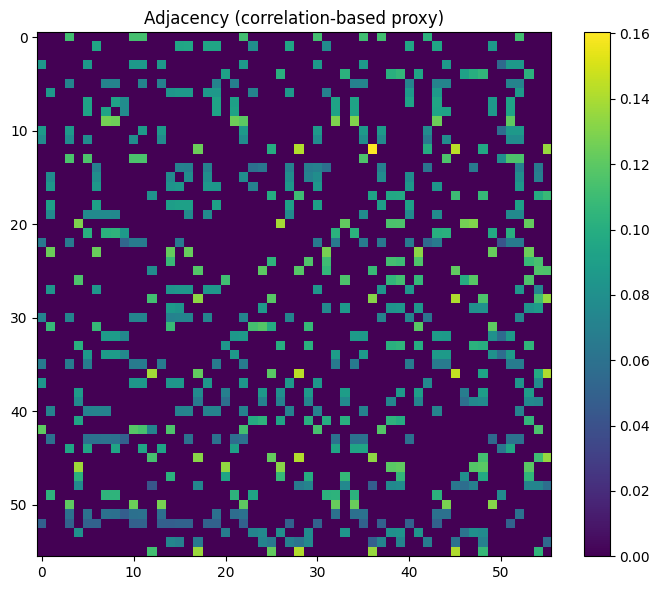

Total windows: 395 train/val/test: 276 59 60
[Mech] ep 001/60 | train_loss=0.000038 val_loss=0.000644 | train_rmse=0.0060 val_rmse=0.0249
[Mech] ep 006/60 | train_loss=0.000008 val_loss=0.000415 | train_rmse=0.0028 val_rmse=0.0198
[Mech] ep 012/60 | train_loss=0.000006 val_loss=0.000217 | train_rmse=0.0024 val_rmse=0.0143
[Mech] ep 018/60 | train_loss=0.000004 val_loss=0.000060 | train_rmse=0.0020 val_rmse=0.0076
[Mech] ep 024/60 | train_loss=0.000004 val_loss=0.000041 | train_rmse=0.0019 val_rmse=0.0063
[Mech] ep 030/60 | train_loss=0.000004 val_loss=0.000120 | train_rmse=0.0019 val_rmse=0.0108
[Mech] ep 036/60 | train_loss=0.000004 val_loss=0.000057 | train_rmse=0.0019 val_rmse=0.0074
[Mech] ep 042/60 | train_loss=0.000003 val_loss=0.000042 | train_rmse=0.0017 val_rmse=0.0064
[Mech] ep 048/60 | train_loss=0.000003 val_loss=0.000056 | train_rmse=0.0017 val_rmse=0.0073
[Mech] ep 054/60 | train_loss=0.000003 val_loss=0.000044 | train_rmse=0.0017 val_rmse=0.0066
[Mech] ep 060/60 | train_

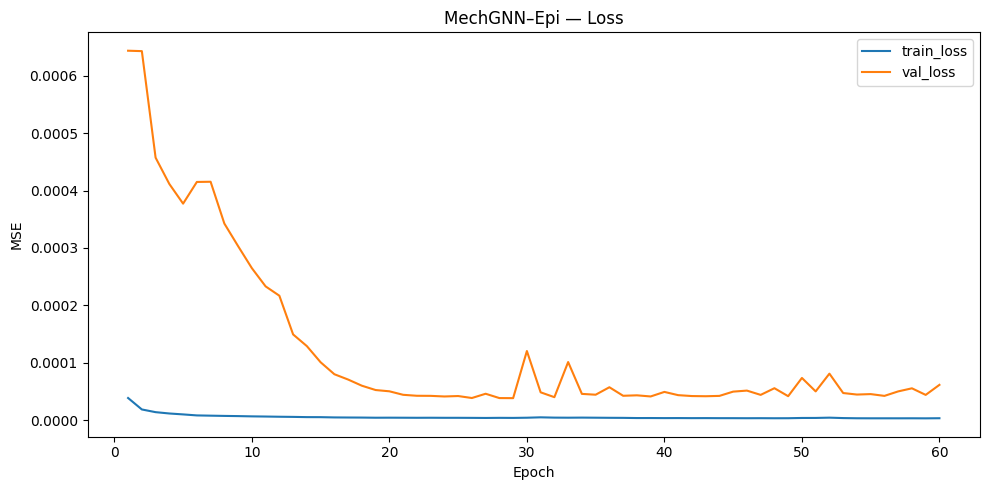

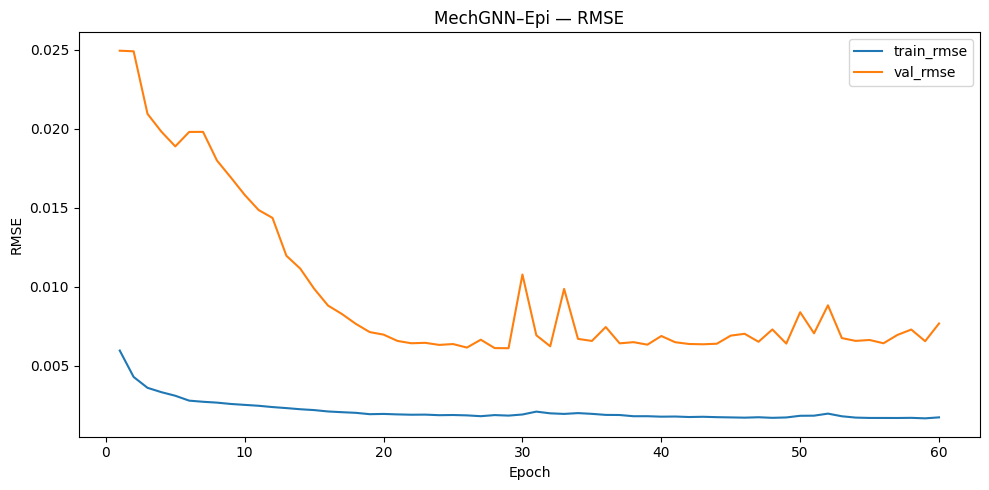

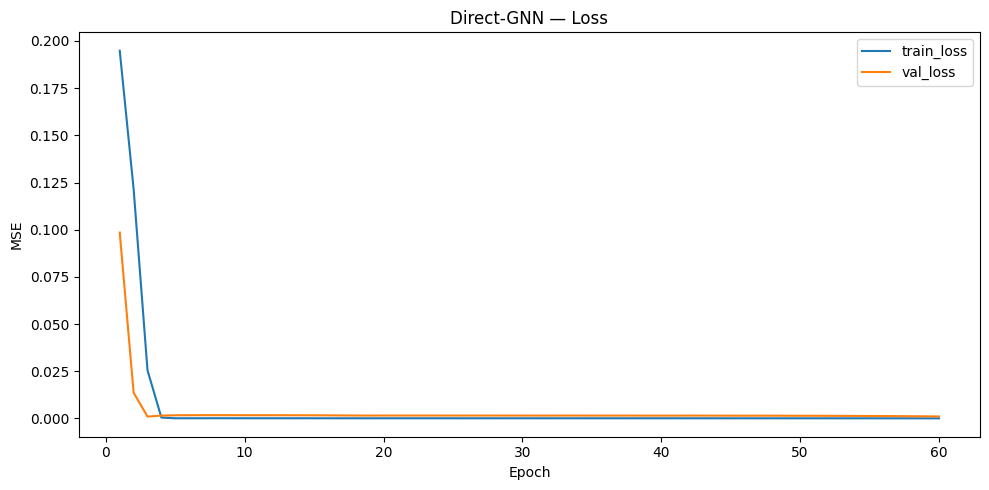

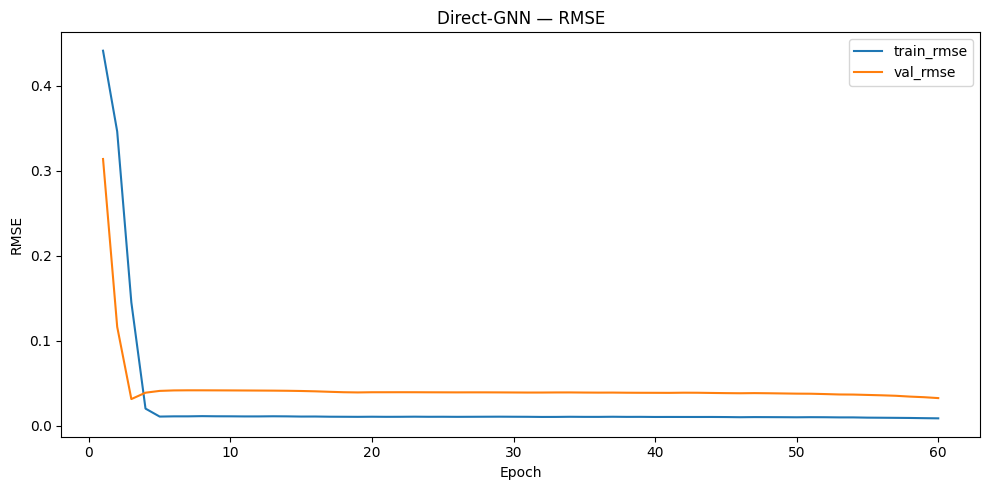


Test metrics (Naive removed):


,model,RMSE,MAE,MAPE
0,MechGNN–Epi,0.011860,0.008944,0.500423
1,Direct-GNN,0.043052,0.029965,262.999390


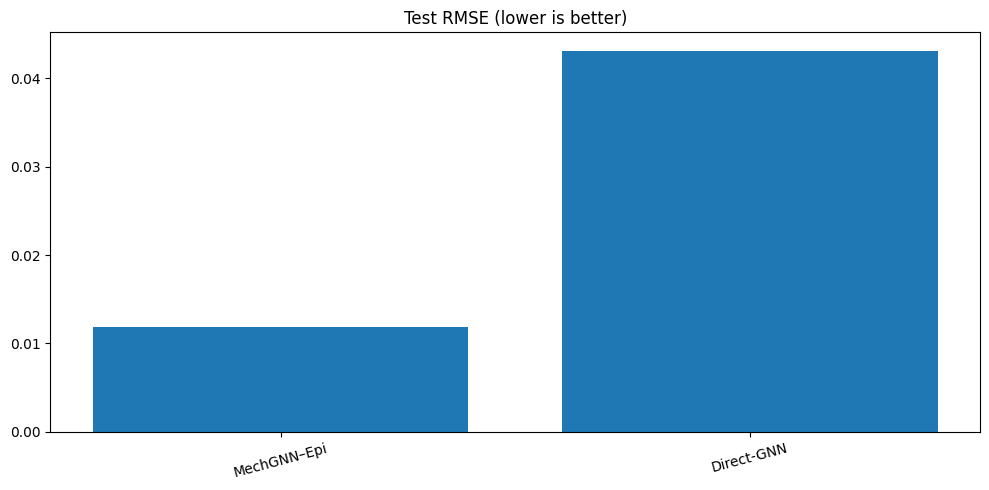

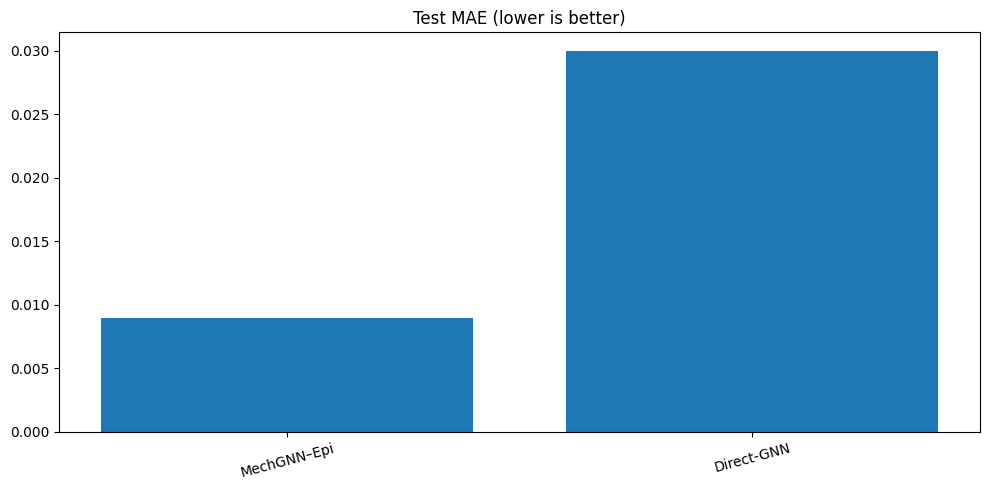

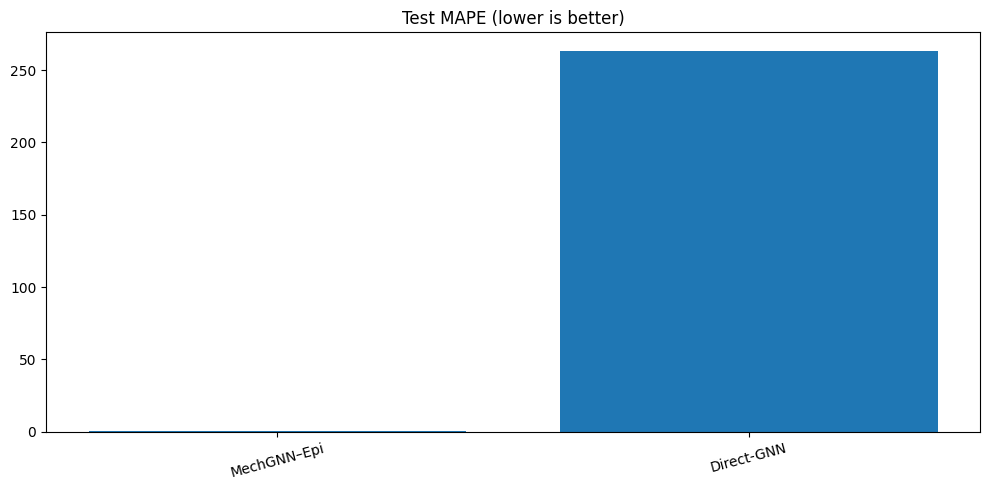

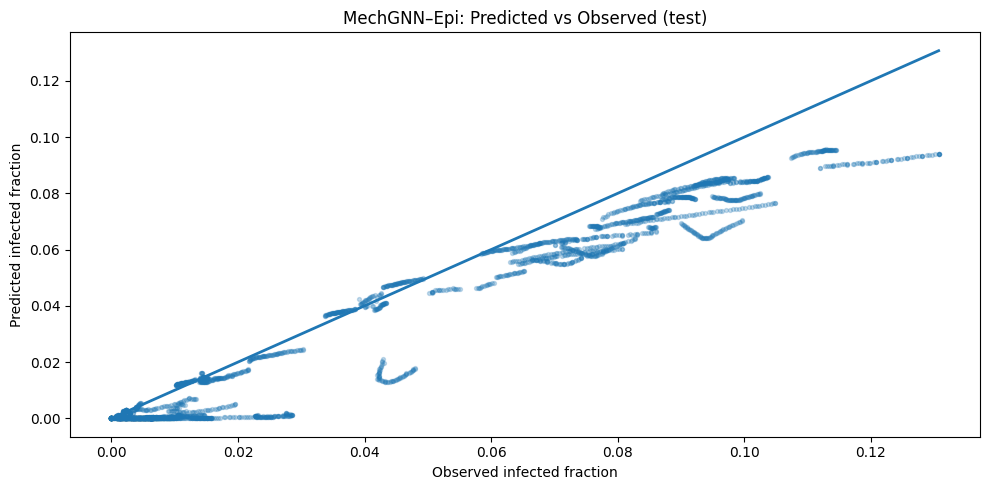

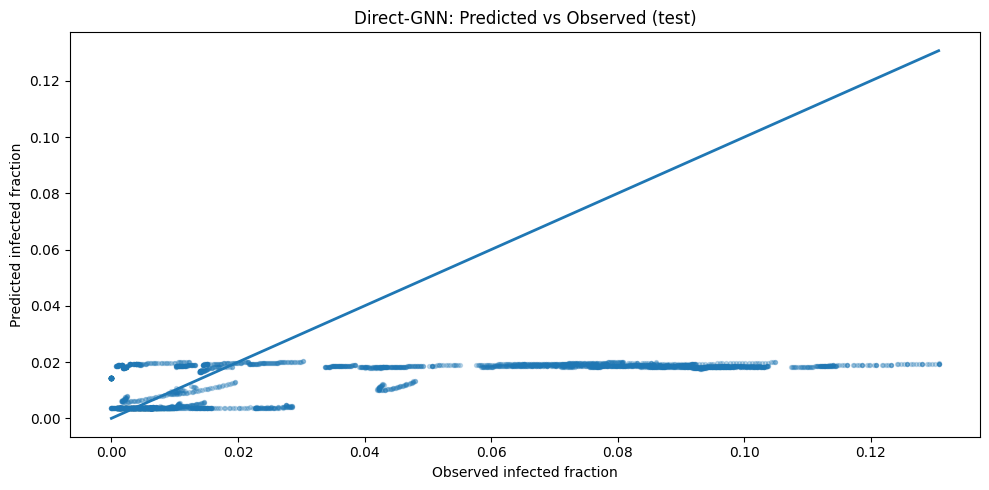

,region,RMSE_MechGNN,RMSE_DirectGNN
0,American Samoa,0.000000,0.014364
1,Northern Mariana Islands,0.000464,0.015986
2,Virgin Islands,0.000649,0.017076
3,Hawaii,0.001315,0.007310
4,Puerto Rico,0.001951,0.002294
5,Oregon,0.001974,0.017460
6,Alabama,0.002146,0.023422
7,Arkansas,0.002537,0.001374
8,Wyoming,0.002555,0.001862
9,Washington,0.002575,0.027517


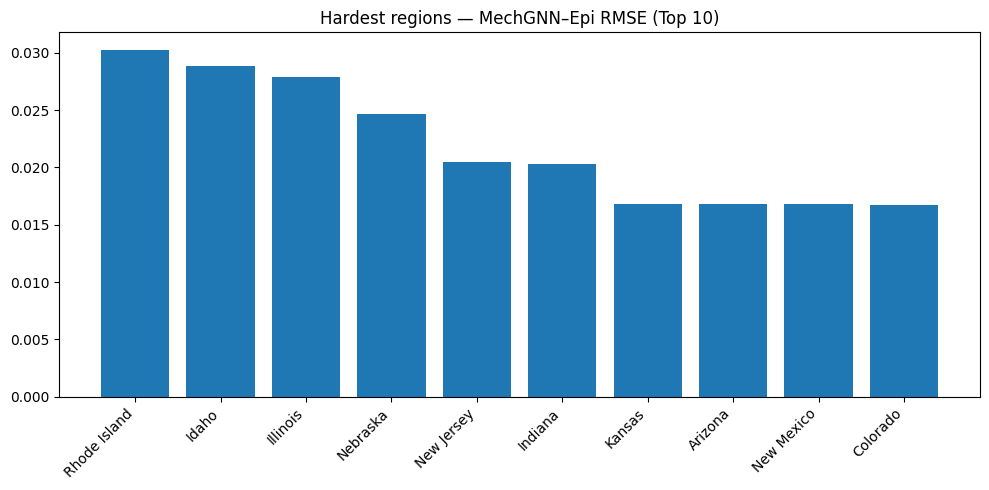

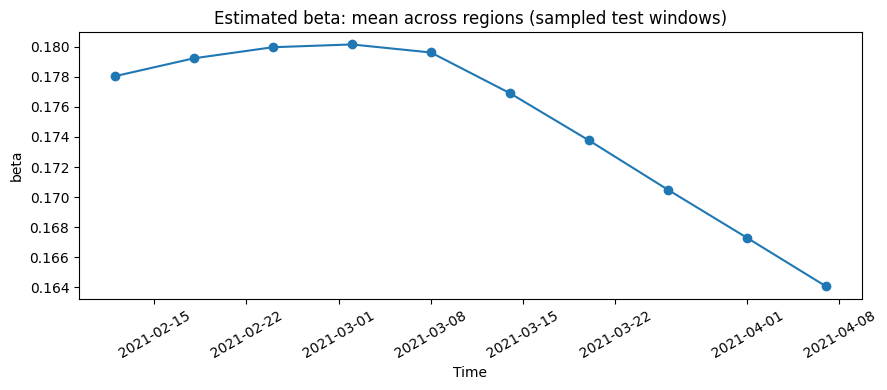

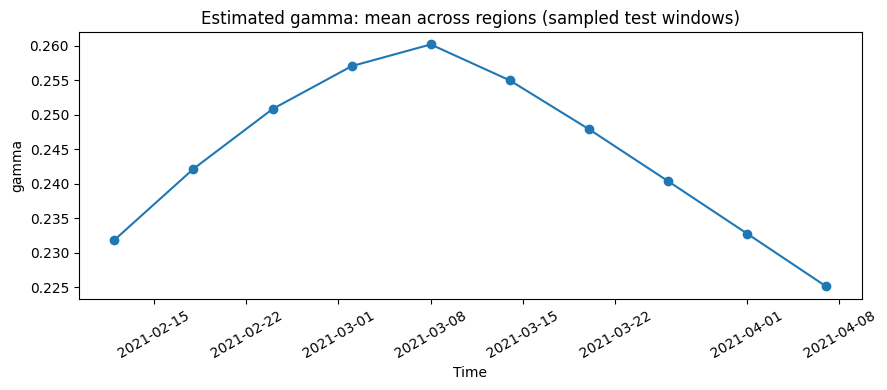

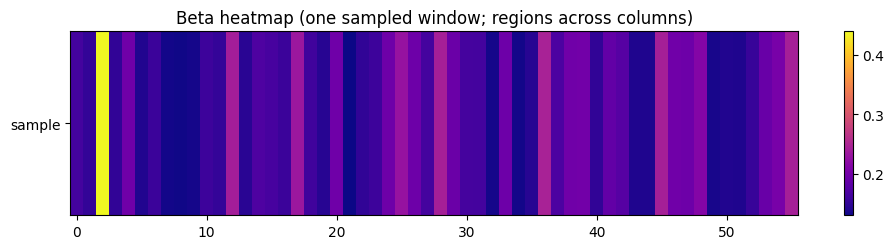

Created ZIP: /content/MechGNN_Epi_Run_20260209_053246.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
# ============================================================
# MechGNN–Epi (Colab) — PIPELINE (Naive removed) + Mechanistic plots saved
# Fixes:
#   - No variable shadowing
#   - Smoothness computed within-window over time (no batch mismatch)
# Implements:
#   ST-GNN encoder -> beta_t,gamma_t per time -> SIR solver -> I_{t+1}
# Baseline: Direct-GNN only (Naive removed)
# Adds (guaranteed saved):
#   beta_mean.png, gamma_mean.png, beta_heatmap_sample.png
# Outputs: plots/tables saved + shown + zipped for download
# ============================================================

import os, io, zipfile, warnings
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from google.colab import files
warnings.filterwarnings("ignore")

# --------------------------
# Repro + device
# --------------------------
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# --------------------------
# Output dir
# --------------------------
run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
OUTDIR = f"/content/MechGNN_Epi_Run_{run_id}"
os.makedirs(OUTDIR, exist_ok=True)
print("Outputs will be saved to:", OUTDIR)

# ============================================================
# 1) Load CSV
# ============================================================

def load_csv_auto():
    for p in ["/content/us_states_covid19dh.csv", "/mnt/data/us_states_covid19dh.csv"]:
        if os.path.exists(p):
            print("Found CSV at:", p)
            return pd.read_csv(p)
    print("\nUpload your CSV now:")
    up = files.upload()
    if len(up) == 0:
        raise ValueError("No CSV uploaded.")
    fn = list(up.keys())[0]
    df = pd.read_csv(io.BytesIO(up[fn]))
    print("Loaded:", fn, "shape:", df.shape)
    return df

df = load_csv_auto()
print("Data shape:", df.shape)
display(df.head())

req = {"date","region","infected","recovered","population","mobility"}
missing = req - set(df.columns)
if missing:
    raise ValueError(f"Missing columns: {missing}. Need: {sorted(req)}")

df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["region","date"]).reset_index(drop=True)

regions = sorted(df["region"].unique().tolist())
dates   = sorted(df["date"].unique().tolist())
N = len(regions)
T = len(dates)

print("Regions:", N, regions[:6], "..." if N>6 else "")
print("Dates:", dates[0], "to", dates[-1], "T =", T)

def pivot(col):
    wide = df.pivot(index="date", columns="region", values=col).reindex(index=dates, columns=regions)
    return wide.values.astype(np.float32)

I_mat = pivot("infected")
R_mat = pivot("recovered")
M_mat = pivot("mobility")

pop_ser = df.drop_duplicates("region").set_index("region").reindex(regions)["population"]
P_vec = pop_ser.values.astype(np.float32)
P_mat = np.tile(P_vec.reshape(1,-1), (T,1)).astype(np.float32)

S_mat = np.clip(P_mat - I_mat - R_mat, 0, None).astype(np.float32)

# Fractions
Sf = S_mat / (P_mat + 1e-6)
If = I_mat / (P_mat + 1e-6)
Rf = R_mat / (P_mat + 1e-6)

# Input features: I_frac, R_frac, mobility
X_full = np.stack([If, Rf, M_mat.astype(np.float32)], axis=-1)  # (T,N,F_in)
F_in = X_full.shape[-1]

# ============================================================
# 2) Adjacency proxy
# ============================================================

def build_adjacency_from_corr(I_frac, eps=1e-6, k=8):
    X = I_frac - I_frac.mean(axis=0, keepdims=True)
    C = np.corrcoef(X.T)
    C = np.nan_to_num(C, nan=0.0, posinf=0.0, neginf=0.0)
    np.fill_diagonal(C, 0.0)

    A = np.zeros_like(C)
    kk = min(k, C.shape[0]-1)
    for i in range(C.shape[0]):
        idx = np.argsort(-C[i])[:kk]
        A[i, idx] = np.maximum(C[i, idx], 0.0)

    A = np.maximum(A, A.T)
    A = A / (A.sum(axis=1, keepdims=True) + eps)
    return A.astype(np.float32)

A = build_adjacency_from_corr(If, k=min(8, max(2, N//6)))
A_t = torch.tensor(A, dtype=torch.float32, device=device)

plt.figure(figsize=(7,6))
plt.imshow(A, aspect="auto", cmap="viridis")
plt.title("Adjacency (correlation-based proxy)")
plt.colorbar()
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "adjacency_heatmap.png"), dpi=200)
plt.show()

# ============================================================
# 3) Sliding windows + rolling split
# ============================================================

L = 14
HORIZON = 1
T_eff = T - L - HORIZON + 1
idx = np.arange(T_eff)

train_frac, val_frac = 0.70, 0.15
n_train = int(train_frac * T_eff)
n_val   = int(val_frac * T_eff)

train_idx = idx[:n_train]
val_idx   = idx[n_train:n_train+n_val]
test_idx  = idx[n_train+n_val:]

print("Total windows:", T_eff, "train/val/test:", len(train_idx), len(val_idx), len(test_idx))

# Standardize features using train prefix
train_end_time = L + train_idx[-1]
X_train_slice = X_full[:train_end_time+1]
mu = X_train_slice.mean(axis=0, keepdims=True)
sd = X_train_slice.std(axis=0, keepdims=True) + 1e-6
Xn = (X_full - mu) / sd

# Tensorize
Xn_t = torch.tensor(Xn, dtype=torch.float32, device=device)
Sf_t = torch.tensor(Sf, dtype=torch.float32, device=device)
If_t = torch.tensor(If, dtype=torch.float32, device=device)
Rf_t = torch.tensor(Rf, dtype=torch.float32, device=device)

def make_batch(window_idxs):
    # returns (B,L,N,F_in), compartments at start-of-roll (B,N), and target (B,N)
    X_hist_list=[]
    S0_list=[]; I0_list=[]; R0_list=[]; Y_list=[]
    for w in window_idxs:
        t0 = w
        t1 = w + L
        t_next = t1 + (HORIZON - 1)

        X_hist_list.append(Xn_t[t0:t1])     # (L,N,F_in)
        S0_list.append(Sf_t[t0])            # start of rollout at time t0
        I0_list.append(If_t[t0])
        R0_list.append(Rf_t[t0])
        Y_list.append(If_t[t_next])         # target infected fraction at t_next

    X_hist = torch.stack(X_hist_list, dim=0)  # (B,L,N,F_in)
    S0 = torch.stack(S0_list, dim=0)
    I0 = torch.stack(I0_list, dim=0)
    R0 = torch.stack(R0_list, dim=0)
    Y  = torch.stack(Y_list,  dim=0)
    return X_hist, S0, I0, R0, Y

# ============================================================
# 4) Model blocks
# ============================================================

class GraphConv(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.lin = nn.Linear(in_dim, out_dim)
    def forward(self, X, A_hat):
        AX = torch.matmul(A_hat, X)  # (B,N,in_dim)
        return self.lin(AX)

class STEncoderTimewise(nn.Module):
    """
    X_hist: (B,L,N,F_in) -> H_seq: (B,L,N,h_dim)
    """
    def __init__(self, in_dim, g_dim=32, h_dim=64):
        super().__init__()
        self.gcn1 = GraphConv(in_dim, g_dim)
        self.gcn2 = GraphConv(g_dim, g_dim)
        self.gru  = nn.GRU(input_size=g_dim, hidden_size=h_dim, batch_first=True)

    def forward(self, X_hist, A_hat):
        Bsz, Lwin, Nnodes, Fin = X_hist.shape
        Z=[]
        for t in range(Lwin):
            Xt = X_hist[:, t, :, :]
            Ht = F.relu(self.gcn1(Xt, A_hat))
            Ht = F.relu(self.gcn2(Ht, A_hat))
            Z.append(Ht)
        Z = torch.stack(Z, dim=1)  # (B,L,N,g_dim)

        Z2 = Z.permute(0,2,1,3).contiguous().view(Bsz*Nnodes, Lwin, -1)
        out, _ = self.gru(Z2)      # (B*N, L, h_dim)
        out = out.view(Bsz, Nnodes, Lwin, -1).permute(0,2,1,3).contiguous()
        return out                 # (B,L,N,h_dim)

class ParameterProxyTimewise(nn.Module):
    """
    H_seq (B,L,N,h) -> beta_seq,gamma_seq (B,L,N) in (0,1)
    """
    def __init__(self, h_dim=64, hidden=64):
        super().__init__()
        self.beta_head = nn.Sequential(nn.Linear(h_dim, hidden), nn.ReLU(), nn.Linear(hidden, 1))
        self.gamma_head = nn.Sequential(nn.Linear(h_dim, hidden), nn.ReLU(), nn.Linear(hidden, 1))

    def forward(self, H_seq):
        Bsz,Lwin,Nnodes,Hd = H_seq.shape
        Hflat = H_seq.reshape(Bsz*Lwin*Nnodes, Hd)
        beta  = torch.sigmoid(self.beta_head(Hflat)).view(Bsz, Lwin, Nnodes)
        gamma = torch.sigmoid(self.gamma_head(Hflat)).view(Bsz, Lwin, Nnodes)
        return beta, gamma

def sir_step(S, I, R, beta, gamma, dt=1.0):
    new_inf = beta * S * I * dt
    new_rec = gamma * I * dt
    S1 = torch.clamp(S - new_inf, min=0.0)
    I1 = torch.clamp(I + new_inf - new_rec, min=0.0)
    R1 = torch.clamp(R + new_rec, min=0.0)
    Z = S1 + I1 + R1
    S1 = S1 / (Z + 1e-8)
    I1 = I1 / (Z + 1e-8)
    R1 = R1 / (Z + 1e-8)
    return S1, I1, R1

class MechGNN_Epi(nn.Module):
    def __init__(self, in_dim, g_dim=32, h_dim=64, hidden=64):
        super().__init__()
        self.enc = STEncoderTimewise(in_dim, g_dim=g_dim, h_dim=h_dim)
        self.ppm = ParameterProxyTimewise(h_dim=h_dim, hidden=hidden)

    def forward(self, X_hist, A_hat, S0, I0, R0):
        H_seq = self.enc(X_hist, A_hat)           # (B,L,N,h)
        beta_seq, gamma_seq = self.ppm(H_seq)     # (B,L,N),(B,L,N)

        S, I, R = S0, I0, R0
        for t in range(beta_seq.shape[1]):
            S, I, R = sir_step(S, I, R, beta_seq[:,t,:], gamma_seq[:,t,:])

        I_pred = I
        return I_pred, beta_seq, gamma_seq

class DirectGNN_Baseline(nn.Module):
    def __init__(self, in_dim, g_dim=32, h_dim=64, hidden=64):
        super().__init__()
        self.enc = STEncoderTimewise(in_dim, g_dim=g_dim, h_dim=h_dim)
        self.head = nn.Sequential(nn.Linear(h_dim, hidden), nn.ReLU(), nn.Linear(hidden, 1))

    def forward(self, X_hist, A_hat):
        H_seq = self.enc(X_hist, A_hat)           # (B,L,N,h)
        H_last = H_seq[:,-1,:,:]                  # (B,N,h)
        I_pred = torch.sigmoid(self.head(H_last)).squeeze(-1)
        return I_pred

# ============================================================
# 5) Train/eval (Naive removed)
# ============================================================

def rmse(yhat, y): return float(torch.sqrt(torch.mean((yhat-y)**2)).item())
def mae(yhat, y):  return float(torch.mean(torch.abs(yhat-y)).item())
def mape(yhat, y, eps=1e-6): return float(torch.mean(torch.abs((yhat-y)/(y+eps))).item())

def train_mech(model, train_idx, val_idx, epochs=60, batch=32, lr=1e-3, lam=5e-3):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    hist={"epoch":[], "train_loss":[], "val_loss":[], "train_rmse":[], "val_rmse":[]}

    for ep in range(1, epochs+1):
        model.train()
        np.random.shuffle(train_idx)
        losses=[]; rmses=[]
        for s in range(0, len(train_idx), batch):
            bidx = train_idx[s:s+batch]
            X_hist, S0, I0, R0, Y = make_batch(bidx)

            I_pred, beta_seq, gamma_seq = model(X_hist, A_t, S0, I0, R0)
            pred_loss = F.mse_loss(I_pred, Y)

            db = beta_seq[:,1:,:] - beta_seq[:,:-1,:]    # within-window smoothness
            smooth = torch.mean(db**2)

            loss = pred_loss + lam * smooth
            opt.zero_grad()
            loss.backward()
            opt.step()

            losses.append(loss.item())
            rmses.append(rmse(I_pred.detach(), Y))

        tr_loss=float(np.mean(losses)); tr_rmse=float(np.mean(rmses))

        model.eval()
        with torch.no_grad():
            v_losses=[]; v_rmses=[]
            for s in range(0, len(val_idx), batch):
                bidx = val_idx[s:s+batch]
                X_hist, S0, I0, R0, Y = make_batch(bidx)
                I_pred, beta_seq, gamma_seq = model(X_hist, A_t, S0, I0, R0)
                v_losses.append(F.mse_loss(I_pred, Y).item())
                v_rmses.append(rmse(I_pred, Y))
            va_loss=float(np.mean(v_losses)); va_rmse=float(np.mean(v_rmses))

        hist["epoch"].append(ep)
        hist["train_loss"].append(tr_loss)
        hist["val_loss"].append(va_loss)
        hist["train_rmse"].append(tr_rmse)
        hist["val_rmse"].append(va_rmse)

        if ep == 1 or ep % max(1, epochs//10) == 0:
            print(f"[Mech] ep {ep:03d}/{epochs} | train_loss={tr_loss:.6f} val_loss={va_loss:.6f} | train_rmse={tr_rmse:.4f} val_rmse={va_rmse:.4f}")

    return pd.DataFrame(hist)

def train_direct(model, train_idx, val_idx, epochs=60, batch=32, lr=1e-3):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    hist={"epoch":[], "train_loss":[], "val_loss":[], "train_rmse":[], "val_rmse":[]}

    for ep in range(1, epochs+1):
        model.train()
        np.random.shuffle(train_idx)
        losses=[]; rmses=[]
        for s in range(0, len(train_idx), batch):
            bidx = train_idx[s:s+batch]
            X_hist, S0, I0, R0, Y = make_batch(bidx)

            I_pred = model(X_hist, A_t)
            loss = F.mse_loss(I_pred, Y)

            opt.zero_grad()
            loss.backward()
            opt.step()

            losses.append(loss.item())
            rmses.append(rmse(I_pred.detach(), Y))

        tr_loss=float(np.mean(losses)); tr_rmse=float(np.mean(rmses))

        model.eval()
        with torch.no_grad():
            v_losses=[]; v_rmses=[]
            for s in range(0, len(val_idx), batch):
                bidx = val_idx[s:s+batch]
                X_hist, S0, I0, R0, Y = make_batch(bidx)
                I_pred = model(X_hist, A_t)
                v_losses.append(F.mse_loss(I_pred, Y).item())
                v_rmses.append(rmse(I_pred, Y))
            va_loss=float(np.mean(v_losses)); va_rmse=float(np.mean(v_rmses))

        hist["epoch"].append(ep)
        hist["train_loss"].append(tr_loss)
        hist["val_loss"].append(va_loss)
        hist["train_rmse"].append(tr_rmse)
        hist["val_rmse"].append(va_rmse)

        if ep == 1 or ep % max(1, epochs//10) == 0:
            print(f"[Direct] ep {ep:03d}/{epochs} | train_loss={tr_loss:.6f} val_loss={va_loss:.6f} | train_rmse={tr_rmse:.4f} val_rmse={va_rmse:.4f}")

    return pd.DataFrame(hist)

def evaluate(mech, direct, test_idx, batch=32):
    mech.eval(); direct.eval()
    all_Y=[]; all_M=[]; all_D=[]
    with torch.no_grad():
        for s in range(0, len(test_idx), batch):
            bidx = test_idx[s:s+batch]
            X_hist, S0, I0, R0, Y = make_batch(bidx)

            M_pred, beta_seq, gamma_seq = mech(X_hist, A_t, S0, I0, R0)
            D_pred = direct(X_hist, A_t)

            all_Y.append(Y.cpu().numpy())
            all_M.append(M_pred.cpu().numpy())
            all_D.append(D_pred.cpu().numpy())

    Y = np.concatenate(all_Y, axis=0)
    M = np.concatenate(all_M, axis=0)
    D = np.concatenate(all_D, axis=0)

    def metrics(name, P):
        y_t=torch.tensor(Y); p_t=torch.tensor(P)
        return {"model":name, "RMSE":rmse(p_t,y_t), "MAE":mae(p_t,y_t), "MAPE":mape(p_t,y_t)}
    dfm = pd.DataFrame([metrics("MechGNN–Epi", M),
                        metrics("Direct-GNN", D)])
    return dfm, (Y,M,D)

# ============================================================
# 6) Train + plots + mechanistic plots + zip
# ============================================================

EPOCHS=60
BATCH=32

mech = MechGNN_Epi(in_dim=F_in, g_dim=32, h_dim=64, hidden=64)
direct = DirectGNN_Baseline(in_dim=F_in, g_dim=32, h_dim=64, hidden=64)

hist_mech = train_mech(mech, train_idx.copy(), val_idx.copy(), epochs=EPOCHS, batch=BATCH, lr=1e-3, lam=5e-3)
hist_direct = train_direct(direct, train_idx.copy(), val_idx.copy(), epochs=EPOCHS, batch=BATCH, lr=1e-3)

hist_mech.to_csv(os.path.join(OUTDIR, "history_mech.csv"), index=False)
hist_direct.to_csv(os.path.join(OUTDIR, "history_direct.csv"), index=False)

def plot_hist(h, title, prefix):
    plt.figure()
    plt.plot(h["epoch"], h["train_loss"], label="train_loss")
    plt.plot(h["epoch"], h["val_loss"], label="val_loss")
    plt.title(title+" — Loss")
    plt.xlabel("Epoch"); plt.ylabel("MSE")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, f"{prefix}_loss.png"), dpi=200)
    plt.show()

    plt.figure()
    plt.plot(h["epoch"], h["train_rmse"], label="train_rmse")
    plt.plot(h["epoch"], h["val_rmse"], label="val_rmse")
    plt.title(title+" — RMSE")
    plt.xlabel("Epoch"); plt.ylabel("RMSE")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, f"{prefix}_rmse.png"), dpi=200)
    plt.show()

plot_hist(hist_mech, "MechGNN–Epi", "mech")
plot_hist(hist_direct, "Direct-GNN", "direct")

metrics_df, (Y,M,D) = evaluate(mech, direct, test_idx, batch=BATCH)
print("\nTest metrics (Naive removed):")
display(metrics_df)
metrics_df.to_csv(os.path.join(OUTDIR, "test_metrics.csv"), index=False)

for metric in ["RMSE","MAE","MAPE"]:
    plt.figure()
    plt.bar(metrics_df["model"], metrics_df[metric])
    plt.title(f"Test {metric} (lower is better)")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, f"bar_{metric}.png"), dpi=200)
    plt.show()

# scatter (Naive removed)
def scatter(y, p, title, fname):
    plt.figure()
    plt.scatter(y.flatten(), p.flatten(), s=8, alpha=0.25)
    mn = float(min(y.min(), p.min()))
    mx = float(max(y.max(), p.max()))
    plt.plot([mn,mx],[mn,mx], linewidth=2)
    plt.title(title)
    plt.xlabel("Observed infected fraction")
    plt.ylabel("Predicted infected fraction")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, fname), dpi=200)
    plt.show()

scatter(Y, M, "MechGNN–Epi: Predicted vs Observed (test)", "scatter_mech.png")
scatter(Y, D, "Direct-GNN: Predicted vs Observed (test)", "scatter_direct.png")

# per-region RMSE table (Naive removed)
rmse_mech = np.sqrt(np.mean((M-Y)**2, axis=0))
rmse_direct = np.sqrt(np.mean((D-Y)**2, axis=0))

per_region = pd.DataFrame({
    "region": regions,
    "RMSE_MechGNN": rmse_mech,
    "RMSE_DirectGNN": rmse_direct
}).sort_values("RMSE_MechGNN").reset_index(drop=True)

display(per_region.head(15))
per_region.to_csv(os.path.join(OUTDIR, "per_region_rmse.csv"), index=False)

hard = per_region.sort_values("RMSE_MechGNN", ascending=False).head(10)
plt.figure(figsize=(10,5))
plt.bar(hard["region"], hard["RMSE_MechGNN"])
plt.title("Hardest regions — MechGNN–Epi RMSE (Top 10)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "hard_regions_mech.png"), dpi=200)
plt.show()

# ------------------------------------------------------------
# Mechanistic plots (GUARANTEED): beta_mean.png, gamma_mean.png, beta_heatmap_sample.png
# We compute beta/gamma for sampled test windows and summarize across regions.
# ------------------------------------------------------------

mech.eval()
sample_windows = test_idx[::max(1, len(test_idx)//10)][:10]  # up to 10 windows
tlabels = []
beta_means = []
gamma_means = []
beta_first = None

with torch.no_grad():
    for w in sample_windows:
        X_hist, S0, I0, R0, Yb = make_batch([w])
        _, beta_seq, gamma_seq = mech(X_hist, A_t, S0, I0, R0)   # beta_seq: (1,L,N)
        beta_last = beta_seq[0, -1, :].cpu().numpy()             # (N,)
        gamma_last = gamma_seq[0, -1, :].cpu().numpy()           # (N,)

        if beta_first is None:
            beta_first = beta_last.copy()

        beta_means.append(beta_last.mean())
        gamma_means.append(gamma_last.mean())
        tlabels.append(dates[w + L - 1])

# beta_mean.png
plt.figure(figsize=(9,4))
plt.plot(tlabels, beta_means, marker="o")
plt.title("Estimated beta: mean across regions (sampled test windows)")
plt.xlabel("Time"); plt.ylabel("beta")
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "beta_mean.png"), dpi=200)
plt.show()

# gamma_mean.png
plt.figure(figsize=(9,4))
plt.plot(tlabels, gamma_means, marker="o")
plt.title("Estimated gamma: mean across regions (sampled test windows)")
plt.xlabel("Time"); plt.ylabel("gamma")
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "gamma_mean.png"), dpi=200)
plt.show()

# beta_heatmap_sample.png (use first sampled window's last-step beta across regions)
plt.figure(figsize=(10,2.6))
plt.imshow(beta_first.reshape(1,-1), aspect="auto", cmap="plasma")
plt.title("Beta heatmap (one sampled window; regions across columns)")
plt.yticks([0], ["sample"])
plt.colorbar()
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "beta_heatmap_sample.png"), dpi=200)
plt.show()

# ============================================================
# Zip + download
# ============================================================

zip_path = f"{OUTDIR}.zip"
with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as z:
    for root, _, fns in os.walk(OUTDIR):
        for fn in fns:
            full = os.path.join(root, fn)
            rel = os.path.relpath(full, OUTDIR)
            z.write(full, arcname=rel)

print("Created ZIP:", zip_path)
files.download(zip_path)
